<a href="https://colab.research.google.com/github/Sarya-Mariam/Oil-Spill-Detection-System/blob/main/Oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from glob import glob
from pathlib import Path


import numpy as np
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split


import albumentations as A

In [2]:
import cv2
import numpy as np
from skimage.restoration import denoise_bilateral

def preprocess_image(img_path, target_size=(256, 256), apply_denoise=True):
    """
    Preprocess satellite image from path:
    1. Load image
    2. Resize to target size
    3. Normalize to [0,1]
    4. Speckle noise reduction
    5. Ensure shape (H, W, C)
    """
    # Load image (RGB)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Image not found: {img_path}")

    # Convert BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize (OpenCV expects (W, H))
    img = cv2.resize(img, (target_size[1], target_size[0]))

    # Normalize
    img = img.astype("float32") / 255.0

    # Denoising (for SAR-like data, but works on RGB too)
    if apply_denoise:
        img = denoise_bilateral(img, sigma_color=0.05, sigma_spatial=5, channel_axis=-1)

    return img


def preprocess_mask(mask_path, target_size=(256, 256)):
    """
    Preprocess mask from path:
    - Load in grayscale
    - Resize
    - Binarize
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Mask not found: {mask_path}")

    mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype("float32")  # binary
    mask = np.expand_dims(mask, axis=-1)   # (H, W, 1)

    return mask

In [3]:
def preprocess_batch(image_paths, mask_paths=None, labels=None,
                     target_size=(256, 256), apply_denoise=True):
    """
    Preprocesses a batch of images, masks, and labels.

    Args:
        image_paths: list of image file paths
        mask_paths: list of mask file paths
        labels: list/array of binary labels
        target_size: resize shape (H, W)
        apply_denoise: apply SAR speckle noise reduction

    Returns:
        preprocessed_images, preprocessed_masks , labels
    """
    X = []
    Y_masks = [] if mask_paths is not None else None
    Y_labels = [] if labels is not None else None

    for i in range(len(image_paths)):
        # Preprocess image
        img = preprocess_image(image_paths[i], target_size=target_size, apply_denoise=apply_denoise)
        X.append(img)

        # Preprocess mask
        if mask_paths is not None:
            mask = preprocess_mask(mask_paths[i], target_size=target_size)
            Y_masks.append(mask)

        # Add label
        if labels is not None:
            Y_labels.append(int(labels[i]))

    X = np.array(X, dtype="float32")
    Y_masks = np.array(Y_masks, dtype="float32") if Y_masks is not None else None
    Y_labels = np.array(Y_labels, dtype="float32") if Y_labels is not None else None

    return X, Y_masks, Y_labels

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_DIR = '/content/drive/MyDrive/oil_spill_dataset'
IMAGES_DIR = os.path.join(DATASET_DIR, 'train', 'images')
MASKS_DIR = os.path.join(DATASET_DIR, 'masks')


IMG_SIZE = 256
BATCH_SIZE = 8
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
!ls "$DATASET_DIR/train/images" | head -20

Oil (1000).jpg
Oil (1001).jpg
Oil (1002).jpg
Oil (1003).jpg
Oil (1004).jpg
Oil (1005).jpg
Oil (1006).jpg
Oil (1009).jpg
Oil (100).jpg
Oil (1010).jpg
Oil (1011).jpg
Oil (1012).jpg
Oil (1013).jpg
Oil (1015).jpg
Oil (1016).jpg
Oil (1017).jpg
Oil (1018).jpg
Oil (101).jpg
Oil (1020).jpg
Oil (1021).jpg


In [6]:
#  Utility functions
def read_image(path, size=IMG_SIZE):
 img = cv2.imread(path, cv2.IMREAD_COLOR)
 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
 img = img.astype('float32') / 255.0
 return img



def read_mask(path, size=IMG_SIZE):
# Read mask, convert to grayscale, then binary (0/1)
 m = cv2.imread(path, cv2.IMREAD_COLOR)
 if m is None:
  raise FileNotFoundError(path)
# If mask is RGB with colored annotations, convert to grayscale first
 gray = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
# Threshold to binary: any non-zero pixel -> 1
 binary = cv2.threshold(gray, 10, 1, cv2.THRESH_BINARY)
 binary = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)
 binary = binary.astype('float32')
# Expand dims for channel
 binary = np.expand_dims(binary, axis=-1)
 return binary




def visualize_pipeline(img_path, mask_path, augmentor=None, size=IMG_SIZE):
 img = read_image(img_path, size)
 mask = read_mask(mask_path, size)


# Apply augmentation if provided
 if augmentor is not None:
  augmented = augmentor(image=(img * 255).astype('uint8'), mask=(mask[:,:,0] * 255).astype('uint8'))
  aug_img = augmented['image'].astype('float32') / 255.0
  aug_mask = augmented['mask'].astype('float32') / 255.0
  aug_mask = np.expand_dims((aug_mask > 0.5).astype('float32'), -1)
 else:
  aug_img, aug_mask = None, None


 fig, axs = plt.subplots(1, 4 if augmentor is not None else 3, figsize=(16, 6))
 axs[0].imshow(img)
 axs[0].set_title('Original Image')
 axs[0].axis('off')


 axs[1].imshow(mask[:,:,0], cmap='gray')
 axs[1].set_title('Original Mask (binary)')
 axs[1].axis('off')


 axs[2].imshow(img)
 axs[2].imshow(mask[:,:,0], cmap='jet', alpha=0.4)
 axs[2].set_title('Overlay (preprocessed)')
 axs[2].axis('off')


 if augmentor is not None:
  axs[3].imshow(aug_img)
  axs[3].imshow(aug_mask[:,:,0], cmap='jet', alpha=0.4)
  axs[3].set_title('Augmented Image + Mask')
  axs[3].axis('off')


 plt.tight_layout()
 plt.show()

In [ ]:
!find /content/drive/MyDrive/oil_spill_dataset -type f | grep -i mask | head -20


/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1062).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1058).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1096).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1045).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1122).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1066).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1099).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1093).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1100).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1128).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1014).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1074).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1104).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1084).png
/content/drive/MyDrive/oil_spill_dataset/val/masks/Oil (1121).png
/content/d

To check the files in your masks directory, run the following code. This will list all files and folders within the `MASKS_DIR`.

In [7]:
#  Gather file lists based on dataset split structure
import glob
from pathlib import Path

BASE_DIR = "/content/drive/MyDrive/oil_spill_dataset"  # change if needed

def load_split(split):
    img_dir = os.path.join(BASE_DIR, split, "images")
    mask_dir = os.path.join(BASE_DIR, split, "masks")

    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Image directory not found: {img_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    image_paths = sorted(glob.glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))

    if len(image_paths) != len(mask_paths):
        print(f"⚠️ Warning: {split} images={len(image_paths)}, masks={len(mask_paths)} (count mismatch)")

    # Show first few pairs
    for i in range(min(3, len(image_paths))):
        print(f"{split} sample -> Image: {Path(image_paths[i]).name}, Mask: {Path(mask_paths[i]).name}")

    return image_paths, mask_paths

# Load splits
train_imgs, train_masks = load_split("train")
val_imgs, val_masks     = load_split("val")
test_imgs, test_masks   = load_split("test") if os.path.exists(os.path.join(BASE_DIR, "test")) else ([], [])

print("Train:", len(train_imgs), "Val:", len(val_imgs), "Test:", len(test_imgs))


train sample -> Image: Oil (1).jpg, Mask: Oil (1).png
train sample -> Image: Oil (10).jpg, Mask: Oil (10).png
train sample -> Image: Oil (100).jpg, Mask: Oil (100).png
val sample -> Image: Oil (1008).jpg, Mask: Oil (1008).png
val sample -> Image: Oil (1014).jpg, Mask: Oil (1014).png
val sample -> Image: Oil (1033).jpg, Mask: Oil (1033).png
test sample -> Image: Oil (1007).jpg, Mask: Oil (1007).png
test sample -> Image: Oil (1019).jpg, Mask: Oil (1019).png
test sample -> Image: Oil (1024).jpg, Mask: Oil (1024).png
Train: 811 Val: 203 Test: 254


In [8]:
def read_mask(path, size=256):
    # Read mask, convert to grayscale
    m = cv2.imread(path, cv2.IMREAD_COLOR)
    if m is None:
        raise FileNotFoundError(path)
    gray = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)

    # Threshold to binary: any non-zero pixel -> 1
    _, binary = cv2.threshold(gray, 10, 1, cv2.THRESH_BINARY)

    # Resize to target size
    binary = cv2.resize(binary, (size, size), interpolation=cv2.INTER_NEAREST)

    # Expand dims for channel
    binary = binary.astype('float32')
    binary = np.expand_dims(binary, axis=-1)
    return binary


In [9]:
# Augmentation setup (albumentations)
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
], additional_targets={'mask': 'mask'})

# For validation/test: only resize/normalize
valid_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
#  tf.data Dataset pipeline

def generator(image_paths, mask_paths, augmentor=None, batch_size=BATCH_SIZE, shuffle=True):
    n = len(image_paths)
    idxs = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(idxs)
        for i in range(0, n, batch_size):
            batch_idxs = idxs[i:i+batch_size]
            imgs = []
            msks = []
            for j in batch_idxs:
                img = read_image(image_paths[j], IMG_SIZE)
                m = read_mask(mask_paths[j], IMG_SIZE)
                if augmentor is not None:
                    aug = augmentor(image=(img*255).astype('uint8'), mask=(m[:,:,0]*255).astype('uint8'))
                    img = aug['image'].astype('float32') / 255.0
                    mask = aug['mask'].astype('float32') / 255.0
                    # ensure binary mask
                    mask = np.expand_dims((mask > 0.5).astype('float32'), -1)
                else:
                    mask = m
                imgs.append(img)
                msks.append(mask)
            imgs = np.stack(imgs, axis=0)
            msks = np.stack(msks, axis=0)
            yield imgs, msks

# Wrap as tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(train_imgs, train_masks, augmentor=train_aug, batch_size=BATCH_SIZE, shuffle=True),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(val_imgs, val_masks, augmentor=None, batch_size=BATCH_SIZE, shuffle=False),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
)

# === Test dataset generator ===
import math
total_test_images = len(test_imgs)
batch_size = BATCH_SIZE
total_test_steps = math.ceil(total_test_images / batch_size)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator(test_imgs, test_masks, augmentor=None, batch_size=BATCH_SIZE, shuffle=False),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 1), dtype=tf.float32),
    )
).apply(tf.data.experimental.assert_cardinality(total_test_steps)) # Explicitly set cardinality


# Prefetching
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [11]:
#  U-Net model definition

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPool2D((2,2))(c)
    return c, p


def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    b = conv_block(p4, 512)

    d4 = decoder_block(b, c4, 256)
    d3 = decoder_block(d4, c3, 128)
    d2 = decoder_block(d3, c2, 64)
    d1 = decoder_block(d2, c1, 32)

    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d1)

    model = keras.Model(inputs, outputs)
    return model

In [12]:
# Losses and metrics

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return bce + dice_loss

In [13]:
# Compile model
model = build_unet()
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.MeanMetricWrapper(iou_coef, name='iou'),
                       tf.keras.metrics.MeanMetricWrapper(dice_coef, name='dice')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 7,858,433 (29.98 MB)

 Trainable params: 7,852,545 (29.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint('unet_oilspill_best.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
]


In [ ]:
# Training
EPOCHS = 10
STEPS_PER_EPOCH = max(1, len(train_imgs) // BATCH_SIZE)
VAL_STEPS = max(1, len(val_imgs) // BATCH_SIZE)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS,
    callbacks=callbacks
)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7309 - dice: 0.7197 - iou: 0.5637 - loss: 0.9161 - precision: 0.9685 - recall: 0.7297

101/101 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - accuracy: 0.7318 - dice: 0.7200 - iou: 0.5640 - loss: 0.9151 - precision: 0.9686 - recall: 0.7307 - val_accuracy: 0.9526 - val_dice: 0.7069 - val_iou: 0.5468 - val_loss: 0.8842 - val_precision: 0.9627 - val_recall: 0.9889 - learning_rate: 1.0000e-04
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9220 - dice: 0.7842 - iou: 0.6457 - loss: 0.6707 - precision: 0.9744 - recall: 0.9396

101/101 ━━━━━━━━━━━━━━━━━━━━ 100s 731ms/step - accuracy: 0.9220 - dice: 0.7843 - iou: 0.6458 - loss: 0.6706 - precision: 0.9744 - recall: 0.9397 - val_accuracy: 0.9560 - val_dice: 0.8521 - val_iou: 0.7427 - val_loss: 0.4617 - val_precision: 0.9618 - val_recall: 0.9936 - learning_rate: 1.0000e-04
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9446 - dice: 0.8171 - iou: 0.6914 - loss: 0.5713 - precision: 0.9760 - recall: 0.9633

101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 717ms/step - accuracy: 0.9446 - dice: 0.8171 - iou: 0.6914 - loss: 0.5712 - precision: 0.9760 - recall: 0.9634 - val_accuracy: 0.9563 - val_dice: 0.8817 - val_iou: 0.7887 - val_loss: 0.3801 - val_precision: 0.9627 - val_recall: 0.9930 - learning_rate: 1.0000e-04
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9461 - dice: 0.8293 - iou: 0.7091 - loss: 0.5477 - precision: 0.9713 - recall: 0.9701

101/101 ━━━━━━━━━━━━━━━━━━━━ 76s 756ms/step - accuracy: 0.9461 - dice: 0.8293 - iou: 0.7091 - loss: 0.5476 - precision: 0.9714 - recall: 0.9701 - val_accuracy: 0.9581 - val_dice: 0.8931 - val_iou: 0.8072 - val_loss: 0.3444 - val_precision: 0.9661 - val_recall: 0.9911 - learning_rate: 1.0000e-04
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9525 - dice: 0.8416 - iou: 0.7274 - loss: 0.5031 - precision: 0.9733 - recall: 0.9755

101/101 ━━━━━━━━━━━━━━━━━━━━ 79s 788ms/step - accuracy: 0.9525 - dice: 0.8417 - iou: 0.7276 - loss: 0.5029 - precision: 0.9732 - recall: 0.9755 - val_accuracy: 0.9623 - val_dice: 0.9066 - val_iou: 0.8294 - val_loss: 0.3072 - val_precision: 0.9719 - val_recall: 0.9893 - learning_rate: 1.0000e-04
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 63s 629ms/step - accuracy: 0.9573 - dice: 0.8607 - iou: 0.7562 - loss: 0.4471 - precision: 0.9735 - recall: 0.9805 - val_accuracy: 0.9625 - val_dice: 0.9067 - val_iou: 0.8297 - val_loss: 0.3093 - val_precision: 0.9715 - val_recall: 0.9899 - learning_rate: 1.0000e-04
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9578 - dice: 0.8747 - iou: 0.7780 - loss: 0.4083 - precision: 0.9737 - recall: 0.9809

101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 823ms/step - accuracy: 0.9577 - dice: 0.8748 - iou: 0.7780 - loss: 0.4083 - precision: 0.9737 - recall: 0.9809 - val_accuracy: 0.9629 - val_dice: 0.9227 - val_iou: 0.8567 - val_loss: 0.2809 - val_precision: 0.9714 - val_recall: 0.9904 - learning_rate: 1.0000e-04
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9616 - dice: 0.8892 - iou: 0.8014 - loss: 0.3650 - precision: 0.9731 - recall: 0.9856

101/101 ━━━━━━━━━━━━━━━━━━━━ 52s 522ms/step - accuracy: 0.9615 - dice: 0.8892 - iou: 0.8013 - loss: 0.3651 - precision: 0.9731 - recall: 0.9856 - val_accuracy: 0.9656 - val_dice: 0.9248 - val_iou: 0.8605 - val_loss: 0.2624 - val_precision: 0.9715 - val_recall: 0.9932 - learning_rate: 1.0000e-04
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9585 - dice: 0.8925 - iou: 0.8065 - loss: 0.3565 - precision: 0.9704 - recall: 0.9853

101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 661ms/step - accuracy: 0.9585 - dice: 0.8926 - iou: 0.8066 - loss: 0.3564 - precision: 0.9703 - recall: 0.9853 - val_accuracy: 0.9662 - val_dice: 0.9247 - val_iou: 0.8603 - val_loss: 0.2623 - val_precision: 0.9708 - val_recall: 0.9947 - learning_rate: 1.0000e-04
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9641 - dice: 0.9083 - iou: 0.8327 - loss: 0.3063 - precision: 0.9730 - recall: 0.9887

101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 664ms/step - accuracy: 0.9641 - dice: 0.9083 - iou: 0.8327 - loss: 0.3063 - precision: 0.9730 - recall: 0.9887 - val_accuracy: 0.9651 - val_dice: 0.9330 - val_iou: 0.8748 - val_loss: 0.2486 - val_precision: 0.9702 - val_recall: 0.9941 - learning_rate: 1.0000e-04


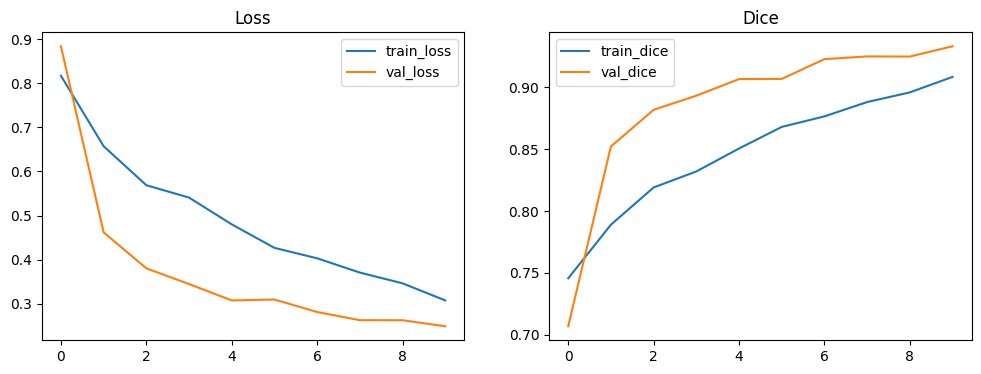

In [ ]:
# Training plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['dice'], label='train_dice')
plt.plot(history.history['val_dice'], label='val_dice')
plt.legend(); plt.title('Dice')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


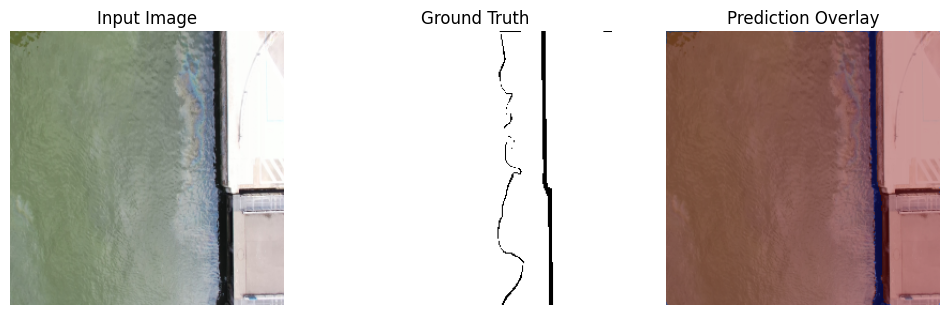

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


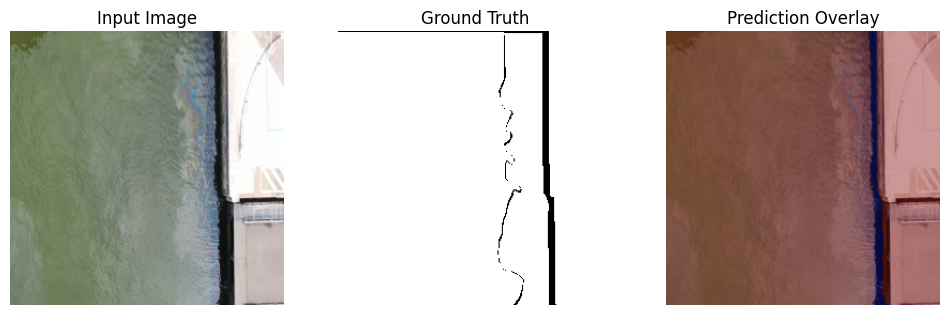

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


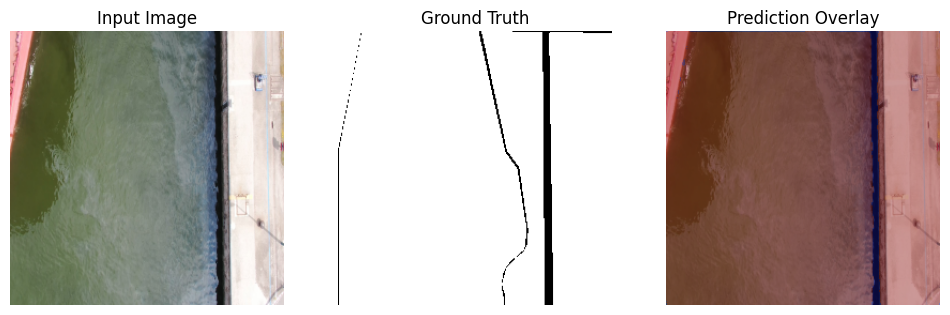

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


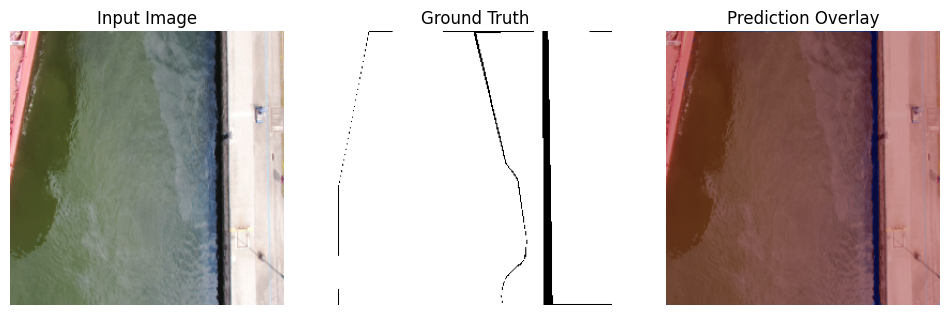

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


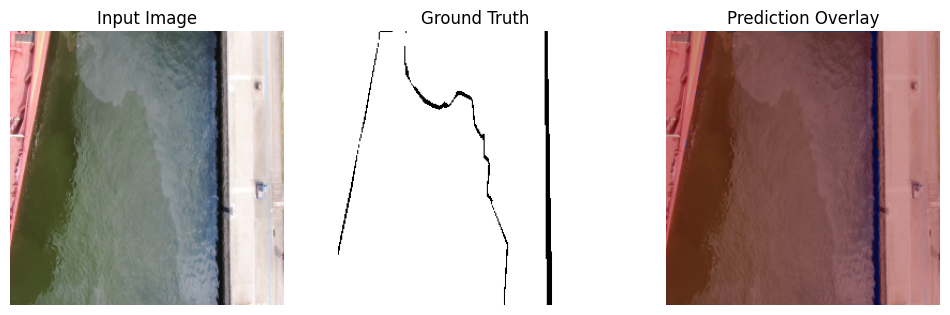

In [ ]:
# Visualize predictions on validation set

def predict_and_plot(sample_img_path, sample_mask_path):
    img = read_image(sample_img_path)
    mask = read_mask(sample_mask_path)
    inp = np.expand_dims(img, 0)
    pred = model.predict(inp)[0]
    pred_bin = (pred[:,:,0] > 0.5).astype('float32')

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(img); axs[0].set_title('Input Image'); axs[0].axis('off')
    axs[1].imshow(mask[:,:,0], cmap='gray'); axs[1].set_title('Ground Truth'); axs[1].axis('off')
    axs[2].imshow(img); axs[2].imshow(pred_bin, cmap='jet', alpha=0.4); axs[2].set_title('Prediction Overlay'); axs[2].axis('off')
    plt.show()

# pick a few val samples
for i in range(min(5, len(val_imgs))):
    predict_and_plot(val_imgs[i], val_masks[i])

In [ ]:
# Save model and notes
model.save('unet_oilspill_final.h5')
print('Model saved to unet_oilspill_final.h5')


Model saved to unet_oilspill_final.h5


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
earlystop  = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reducelr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7)

callbacks = [checkpoint, earlystop, reducelr]

# Training
EPOCHS = 20
STEPS_PER_EPOCH = max(1, len(train_imgs) // BATCH_SIZE)
VAL_STEPS = max(1, len(val_imgs) // BATCH_SIZE)

history = model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9580 - dice: 0.9105 - iou: 0.8365 - loss: 0.3098 - precision: 0.9682 - recall: 0.9869

101/101 ━━━━━━━━━━━━━━━━━━━━ 75s 737ms/step - accuracy: 0.9580 - dice: 0.9105 - iou: 0.8364 - loss: 0.3099 - precision: 0.9682 - recall: 0.9869 - val_accuracy: 0.9632 - val_dice: 0.9283 - val_iou: 0.8667 - val_loss: 0.2516 - val_precision: 0.9700 - val_recall: 0.9923 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9652 - dice: 0.9191 - iou: 0.8509 - loss: 0.2802 - precision: 0.9740 - recall: 0.9890

101/101 ━━━━━━━━━━━━━━━━━━━━ 73s 732ms/step - accuracy: 0.9652 - dice: 0.9191 - iou: 0.8508 - loss: 0.2803 - precision: 0.9739 - recall: 0.9891 - val_accuracy: 0.9654 - val_dice: 0.9358 - val_iou: 0.8797 - val_loss: 0.2368 - val_precision: 0.9700 - val_recall: 0.9947 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9608 - dice: 0.9253 - iou: 0.8617 - loss: 0.2650 - precision: 0.9669 - recall: 0.9914

101/101 ━━━━━━━━━━━━━━━━━━━━ 74s 738ms/step - accuracy: 0.9608 - dice: 0.9253 - iou: 0.8617 - loss: 0.2650 - precision: 0.9669 - recall: 0.9914 - val_accuracy: 0.9658 - val_dice: 0.9452 - val_iou: 0.8963 - val_loss: 0.2078 - val_precision: 0.9697 - val_recall: 0.9955 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 713ms/step - accuracy: 0.9638 - dice: 0.9321 - iou: 0.8734 - loss: 0.2437 - precision: 0.9695 - recall: 0.9920 - val_accuracy: 0.9657 - val_dice: 0.9416 - val_iou: 0.8899 - val_loss: 0.2206 - val_precision: 0.9699 - val_recall: 0.9952 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9525 - dice: 0.9249 - iou: 0.8615 - loss: 0.2881 - precision: 0.9638 - recall: 0.9854

101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 714ms/step - accuracy: 0.9526 - dice: 0.9250 - iou: 0.8616 - loss: 0.2877 - precision: 0.9639 - recall: 0.9855 - val_accuracy: 0.9661 - val_dice: 0.9516 - val_iou: 0.9080 - val_loss: 0.1925 - val_precision: 0.9688 - val_recall: 0.9967 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9682 - dice: 0.9386 - iou: 0.8847 - loss: 0.2172 - precision: 0.9729 - recall: 0.9934

101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 670ms/step - accuracy: 0.9682 - dice: 0.9386 - iou: 0.8847 - loss: 0.2172 - precision: 0.9728 - recall: 0.9934 - val_accuracy: 0.9662 - val_dice: 0.9533 - val_iou: 0.9112 - val_loss: 0.1778 - val_precision: 0.9687 - val_recall: 0.9970 - learning_rate: 1.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 656ms/step - accuracy: 0.9594 - dice: 0.9410 - iou: 0.8892 - loss: 0.2208 - precision: 0.9642 - recall: 0.9925 - val_accuracy: 0.9662 - val_dice: 0.9526 - val_iou: 0.9099 - val_loss: 0.1795 - val_precision: 0.9679 - val_recall: 0.9979 - learning_rate: 1.0000e-04
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 666ms/step - accuracy: 0.9652 - dice: 0.9461 - iou: 0.8982 - loss: 0.2028 - precision: 0.9695 - recall: 0.9936 - val_accuracy: 0.9658 - val_dice: 0.9562 - val_iou: 0.9164 - val_loss: 0.1817 - val_precision: 0.9702 - val_recall: 0.9950 - learning_rate: 1.0000e-04
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9683 - dice: 0.9494 - 

101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 669ms/step - accuracy: 0.9682 - dice: 0.9494 - iou: 0.9041 - loss: 0.1912 - precision: 0.9731 - recall: 0.9932 - val_accuracy: 0.9662 - val_dice: 0.9592 - val_iou: 0.9220 - val_loss: 0.1688 - val_precision: 0.9703 - val_recall: 0.9952 - learning_rate: 1.0000e-04
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9669 - dice: 0.9518 - iou: 0.9085 - loss: 0.1882 - precision: 0.9717 - recall: 0.9932

101/101 ━━━━━━━━━━━━━━━━━━━━ 69s 688ms/step - accuracy: 0.9668 - dice: 0.9518 - iou: 0.9084 - loss: 0.1883 - precision: 0.9717 - recall: 0.9932 - val_accuracy: 0.9661 - val_dice: 0.9619 - val_iou: 0.9269 - val_loss: 0.1656 - val_precision: 0.9689 - val_recall: 0.9967 - learning_rate: 1.0000e-04
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9600 - dice: 0.9512 - iou: 0.9074 - loss: 0.1952 - precision: 0.9637 - recall: 0.9937

101/101 ━━━━━━━━━━━━━━━━━━━━ 68s 681ms/step - accuracy: 0.9600 - dice: 0.9512 - iou: 0.9075 - loss: 0.1951 - precision: 0.9637 - recall: 0.9937 - val_accuracy: 0.9662 - val_dice: 0.9624 - val_iou: 0.9278 - val_loss: 0.1567 - val_precision: 0.9697 - val_recall: 0.9958 - learning_rate: 1.0000e-04
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 65s 644ms/step - accuracy: 0.9566 - dice: 0.9496 - iou: 0.9046 - loss: 0.2095 - precision: 0.9608 - recall: 0.9929 - val_accuracy: 0.9665 - val_dice: 0.9610 - val_iou: 0.9252 - val_loss: 0.1761 - val_precision: 0.9694 - val_recall: 0.9966 - learning_rate: 1.0000e-04
Epoch 13/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 665ms/step - accuracy: 0.9669 - dice: 0.9576 - iou: 0.9190 - loss: 0.1737 - precision: 0.9702 - recall: 0.9948 - val_accuracy: 0.9665 - val_dice: 0.9578 - val_iou: 0.9194 - val_loss: 0.1729 - val_precision: 0.9698 - val_recall: 0.9961 - learning_rate: 1.0000e-04
Epoch 14/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9613 - dice: 0.9556

101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 657ms/step - accuracy: 0.9613 - dice: 0.9557 - iou: 0.9156 - loss: 0.1864 - precision: 0.9647 - recall: 0.9943 - val_accuracy: 0.9666 - val_dice: 0.9688 - val_iou: 0.9400 - val_loss: 0.1508 - val_precision: 0.9691 - val_recall: 0.9969 - learning_rate: 1.0000e-04
Epoch 15/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9687 - dice: 0.9626 - iou: 0.9282 - loss: 0.1570 - precision: 0.9723 - recall: 0.9944

101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 653ms/step - accuracy: 0.9687 - dice: 0.9626 - iou: 0.9282 - loss: 0.1570 - precision: 0.9723 - recall: 0.9944 - val_accuracy: 0.9667 - val_dice: 0.9659 - val_iou: 0.9345 - val_loss: 0.1494 - val_precision: 0.9697 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 16/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 653ms/step - accuracy: 0.9602 - dice: 0.9597 - iou: 0.9230 - loss: 0.1812 - precision: 0.9630 - recall: 0.9946 - val_accuracy: 0.9656 - val_dice: 0.9656 - val_iou: 0.9341 - val_loss: 0.1528 - val_precision: 0.9687 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 17/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9650 - dice: 0.9608 - iou: 0.9251 - loss: 0.1682 - precision: 0.9686 - recall: 0.9943

101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 667ms/step - accuracy: 0.9650 - dice: 0.9608 - iou: 0.9251 - loss: 0.1683 - precision: 0.9686 - recall: 0.9943 - val_accuracy: 0.9665 - val_dice: 0.9647 - val_iou: 0.9323 - val_loss: 0.1483 - val_precision: 0.9690 - val_recall: 0.9970 - learning_rate: 1.0000e-04
Epoch 18/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9664 - dice: 0.9635 - iou: 0.9298 - loss: 0.1569 - precision: 0.9695 - recall: 0.9948

101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 655ms/step - accuracy: 0.9664 - dice: 0.9635 - iou: 0.9298 - loss: 0.1569 - precision: 0.9695 - recall: 0.9948 - val_accuracy: 0.9668 - val_dice: 0.9680 - val_iou: 0.9384 - val_loss: 0.1404 - val_precision: 0.9692 - val_recall: 0.9971 - learning_rate: 1.0000e-04
Epoch 19/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9595 - dice: 0.9609 - iou: 0.9254 - loss: 0.1757 - precision: 0.9626 - recall: 0.9945

101/101 ━━━━━━━━━━━━━━━━━━━━ 67s 665ms/step - accuracy: 0.9596 - dice: 0.9609 - iou: 0.9254 - loss: 0.1756 - precision: 0.9626 - recall: 0.9945 - val_accuracy: 0.9668 - val_dice: 0.9667 - val_iou: 0.9360 - val_loss: 0.1388 - val_precision: 0.9694 - val_recall: 0.9969 - learning_rate: 1.0000e-04
Epoch 20/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 654ms/step - accuracy: 0.9699 - dice: 0.9663 - iou: 0.9349 - loss: 0.1442 - precision: 0.9729 - recall: 0.9953 - val_accuracy: 0.9659 - val_dice: 0.9695 - val_iou: 0.9411 - val_loss: 0.1418 - val_precision: 0.9707 - val_recall: 0.9944 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


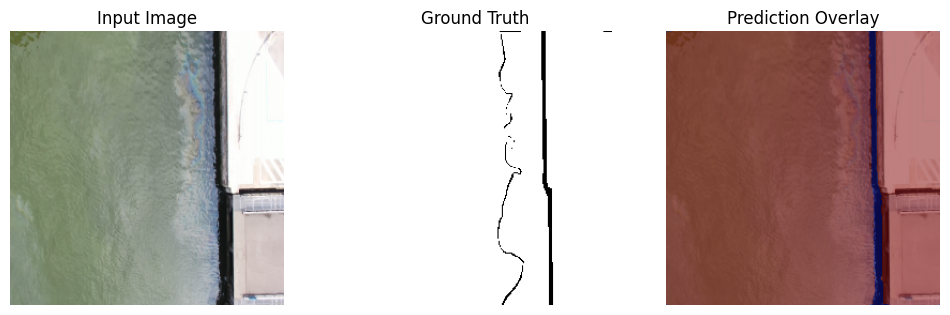

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


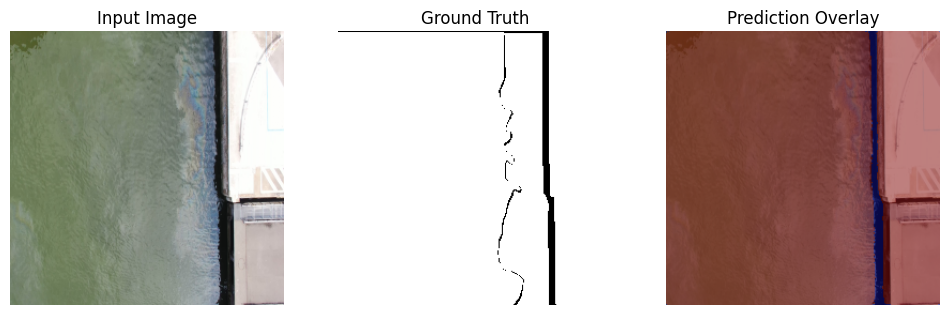

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


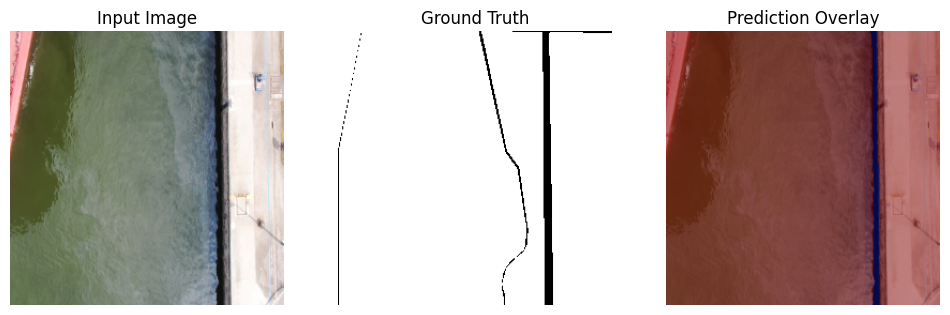

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


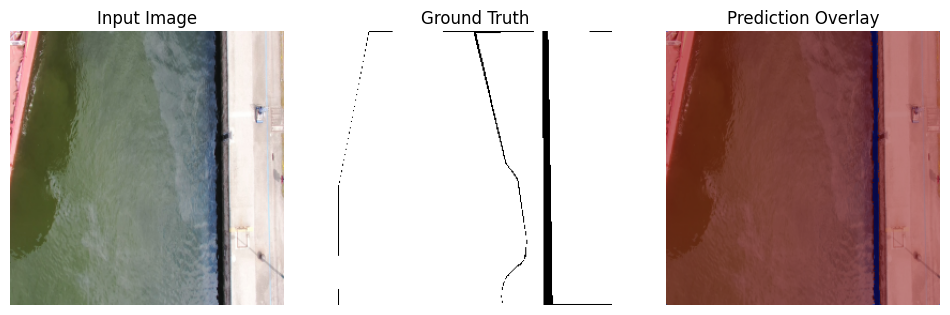

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


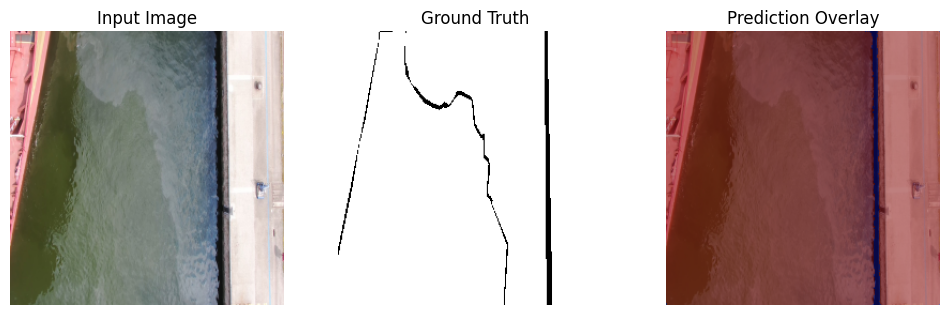

In [ ]:
def show_predictions(image_paths, mask_paths, model, n=3):
    for i in range(n):
        img = read_image(image_paths[i])
        mask = read_mask(mask_paths[i])
        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > 0.5).astype("float32")

        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
        axs[1].imshow(mask[:,:,0], cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(img); axs[2].imshow(pred_bin, cmap="jet", alpha=0.5); axs[2].set_title("Prediction Overlay"); axs[2].axis("off")
        plt.show()

# Example usage: show results from validation set
show_predictions(val_imgs, val_masks, model, n=5)

In [ ]:
results = model.evaluate(test_ds)
print("Test set evaluation:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 233s 7s/step - accuracy: 0.9644 - dice: 0.9654 - iou: 0.9334 - loss: 0.1478 - precision: 0.9672 - recall: 0.9966
Test set evaluation:
loss: 0.1343
compile_metrics: 0.9694


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

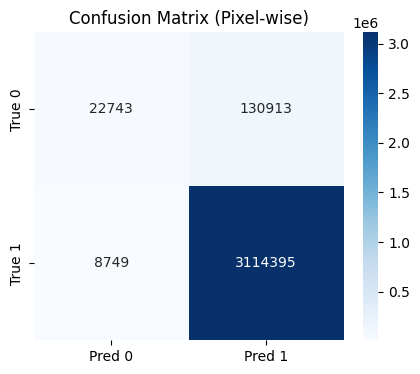

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_confusion_matrix_metrics(model, img_paths, mask_paths, threshold=0.5, n_samples=50):
    """
    Computes pixel-wise confusion matrix and metrics (Precision, Recall, F1, IoU).
    """
    y_true_all, y_pred_all = [], []

    # Collect predictions for a subset of test images
    for i in range(min(n_samples, len(img_paths))):
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])

        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > threshold).astype("int").flatten()
        mask_bin = mask[:,:,0].astype("int").flatten()

        y_true_all.extend(mask_bin)
        y_pred_all.extend(pred_bin)

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    TN, FP, FN, TP = cm.ravel()

    # Metrics
    precision = TP / (TP + FP + 1e-7)
    recall    = TP / (TP + FN + 1e-7)
    f1_score  = 2 * precision * recall / (precision + recall + 1e-7)
    iou       = TP / (TP + FP + FN + 1e-7)

    metrics = {
        "TN": TN, "FP": FP, "FN": FN, "TP": TP,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1_score,
        "IoU": iou
    }
    return cm, metrics

# Run evaluation
cm, metrics = evaluate_confusion_matrix_metrics(model, test_imgs, test_masks)

print("\n🧾 Confusion Matrix (pixel-wise):")
print(cm)

print("\n📊 Derived Metrics from Confusion Matrix:")
for k,v in metrics.items():
    print(f"{k:10s}: {v:.4f}" if isinstance(v,float) else f"{k:10s}: {v}")

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Pixel-wise)")
plt.show()

In [ ]:
import os

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✅ Results will be saved to: {RESULTS_DIR}/")

✅ Results will be saved to: results/


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

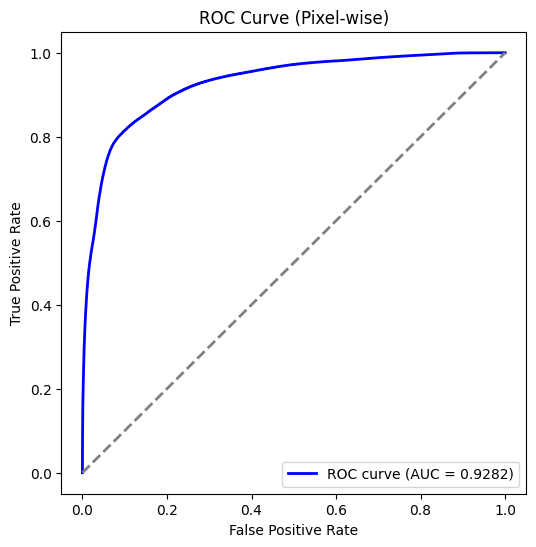

📊 Saved ROC curve → results/roc_curve.png
📈 AUC score (pixel-wise): 0.9282


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc_auc(model, img_paths, mask_paths, n_samples=50):
    """
    Computes ROC curve and AUC for pixel-wise classification.
    """
    y_true_all, y_pred_all = [], []

    for i in range(min(n_samples, len(img_paths))):
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])

        # Model prediction probabilities
        pred = model.predict(np.expand_dims(img, 0))[0][:,:,0].flatten()
        mask_bin = mask[:,:,0].astype("int").flatten()

        y_true_all.extend(mask_bin)
        y_pred_all.extend(pred)  # keep probabilities, not thresholded

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true_all, y_pred_all)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="gray", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Pixel-wise)")
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, "roc_curve.png"))
    plt.close()
    print("📊 Saved ROC curve → results/roc_curve.png")

    return roc_auc

# Run ROC evaluation
roc_auc = evaluate_roc_auc(model, test_imgs, test_masks)
print(f"📈 AUC score (pixel-wise): {roc_auc:.4f}")


In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Pixel-wise)")
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"))
plt.close()
print("📊 Saved confusion matrix → results/confusion_matrix.png")

📊 Saved confusion matrix → results/confusion_matrix.png


In [ ]:
def save_predictions(img_paths, mask_paths, model, n=5):
    for i in range(n):
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])
        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > 0.5).astype("float32")

        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
        axs[1].imshow(mask[:,:,0], cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(img); axs[2].imshow(pred_bin, cmap="jet", alpha=0.5); axs[2].set_title("Prediction"); axs[2].axis("off")

        plt.savefig(os.path.join(RESULTS_DIR, f"prediction_{i+1}.png"))
        plt.close()
    print(f"📊 Saved {n} prediction visualizations → results/prediction_*.png")

save_predictions(test_imgs, test_masks, model, n=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
📊 Saved 5 prediction visualizations → results/prediction_*.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


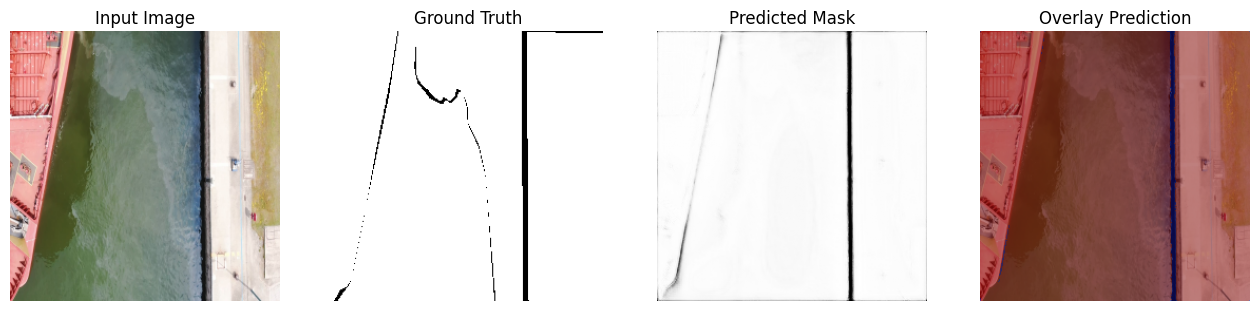

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


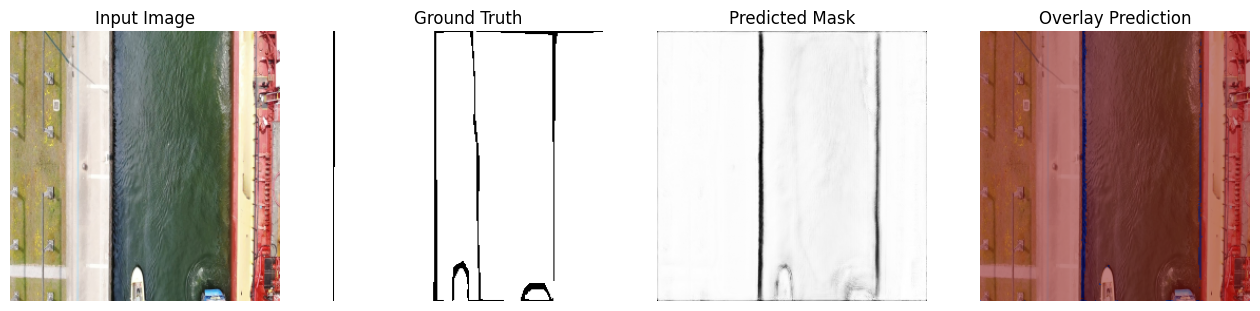

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


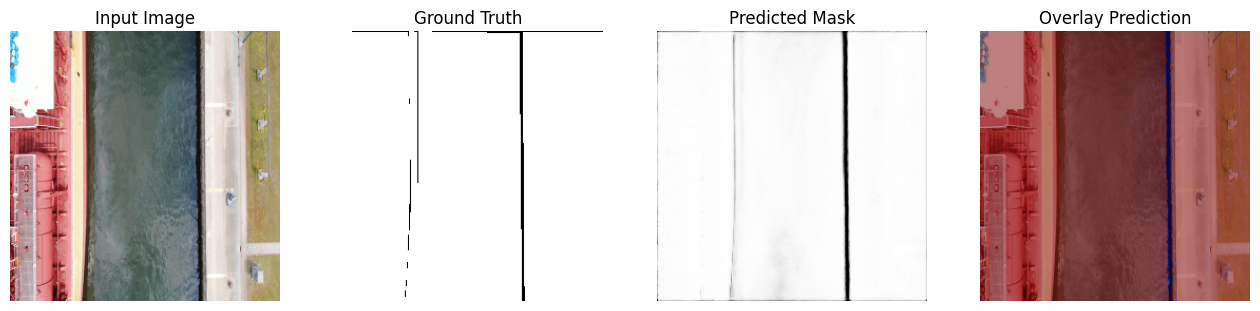

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


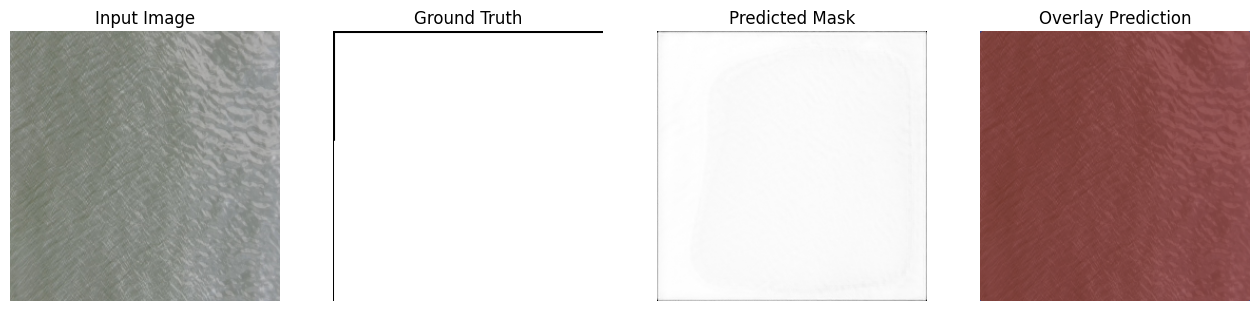

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


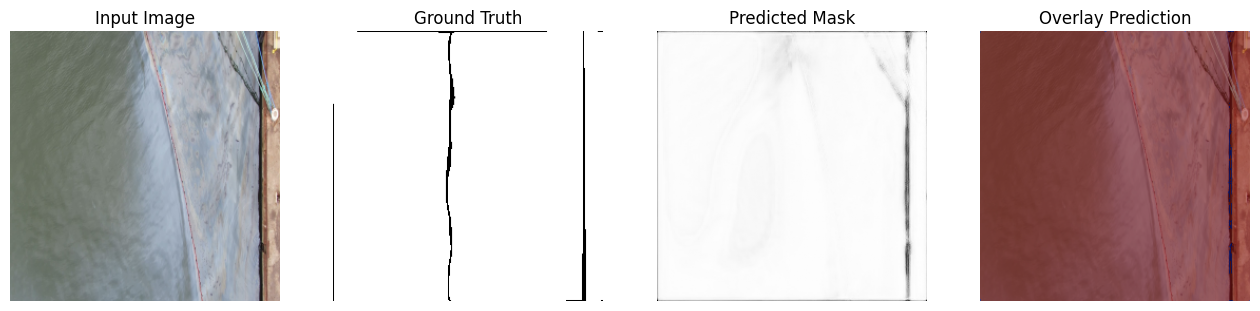

In [ ]:
# === Cell: Visualization of predictions on multiple samples ===
def visualize_results(img_paths, mask_paths, model, n=5):
    sample_idx = np.random.choice(len(img_paths), n, replace=False)
    for i in sample_idx:
        img = read_image(img_paths[i])
        mask = read_mask(mask_paths[i])
        pred = model.predict(np.expand_dims(img, 0))[0]
        pred_bin = (pred[:,:,0] > 0.5).astype('float32')

        fig, axs = plt.subplots(1, 4, figsize=(16, 6))
        axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
        axs[1].imshow(mask[:,:,0], cmap="gray"); axs[1].set_title("Ground Truth"); axs[1].axis("off")
        axs[2].imshow(pred[:,:,0], cmap="gray"); axs[2].set_title("Predicted Mask"); axs[2].axis("off")
        axs[3].imshow(img); axs[3].imshow(pred_bin, cmap="jet", alpha=0.5)
        axs[3].set_title("Overlay Prediction"); axs[3].axis("off")
        plt.show()

# Run visualization on validation set
visualize_results(val_imgs, val_masks, model, n=5)

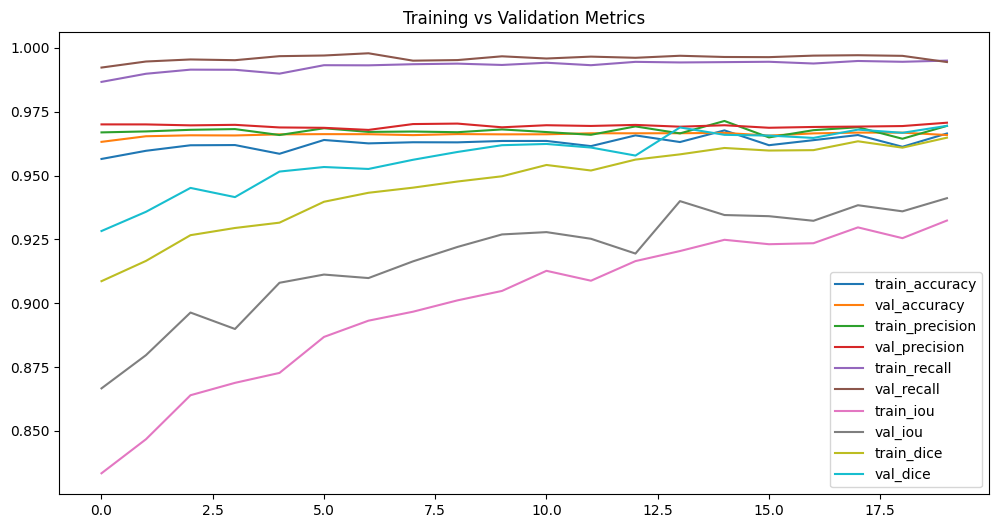

In [ ]:
# === Cell: Plot metrics summary ===
metrics = ["accuracy", "precision", "recall", "iou", "dice"]
plt.figure(figsize=(12,6))
for m in metrics:
    plt.plot(history.history[m], label=f"train_{m}")
    plt.plot(history.history[f"val_{m}"], label=f"val_{m}")
plt.legend(); plt.title("Training vs Validation Metrics")
plt.savefig(os.path.join(RESULTS_DIR, "training_metrics_plot.png")) # Save the figure
plt.show()

Dual-Head U-Net (Segmentation + Classification)

In [15]:
from tensorflow.keras import layers, models

def dual_head_unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Shared Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder (Segmentation head)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # Segmentation head
    seg_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name="segmentation")(c9)

    # Classification head (Global pooling on bottleneck)
    cls_head = layers.GlobalAveragePooling2D()(c5)
    cls_head = layers.Dense(128, activation="relu")(cls_head)
    cls_output = layers.Dense(1, activation="sigmoid", name="classification")(cls_head)

    model = models.Model(inputs=inputs, outputs=[seg_output, cls_output])
    return model

dual_model = dual_head_unet()

dual_model.compile(
    optimizer="adam",
    loss={
        "segmentation": "binary_crossentropy",
        "classification": "binary_crossentropy"
    },
    metrics={
        "segmentation": ["accuracy"],
        "classification": ["accuracy"]
    }
)

dual_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,163,074 (118.88 MB)

 Trainable params: 31,163,074 (118.88 MB)

 Non-trainable params: 0 (0.00 B)

Inference Function for Dual-Head U-Net

In [16]:
import matplotlib.pyplot as plt

def predict_dual_model(img, model, threshold=0.5):
    # Preprocess image
    processed = preprocess_image(img, target_size=(256, 256))
    processed = np.expand_dims(processed, axis=0)  # add batch
    if processed.shape[-1] != 3:  # ensure 3 channels
        processed = np.repeat(processed[..., np.newaxis], 3, axis=-1)

    # Get predictions
    seg_pred, cls_pred = model.predict(processed)

    # Classification
    spill_prob = cls_pred[0][0]
    label = "Spill" if spill_prob > threshold else "Non-Spill"

    # Visualization
    plt.figure(figsize=(12,4))

    if label == "Spill":
        seg_mask = (seg_pred[0,:,:,0] > 0.5).astype(np.uint8)

        plt.subplot(1,3,1)
        plt.imshow(processed[0])
        plt.title("Input")

        plt.subplot(1,3,2)
        plt.imshow(seg_mask, cmap="jet")
        plt.title("Predicted Mask")

        plt.subplot(1,3,3)
        plt.imshow(processed[0])
        plt.imshow(seg_mask, cmap="jet", alpha=0.5)
        plt.title(f"Overlay ({label}, {spill_prob:.2f})")

    else:
        plt.imshow(processed[0])
        plt.title(f"{label} ({spill_prob:.2f})")

    plt.show()

    return label, spill_prob

# Example usage:
# label, prob = predict_dual_model(test_image, dual_model)
# print("Prediction:", label, "with probability:", prob)

Build a Custom Data Generator

In [17]:
import tensorflow as tf
import numpy as np

class DualHeadDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, augment_fn=None):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment_fn = augment_fn
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_imgs = []
        batch_masks = []
        batch_cls = []

        for i in batch_indices:
            img = self.images[i]
            mask = self.masks[i]

            # Preprocess
            img = preprocess_image(img, target_size=(256,256))
            mask = preprocess_mask(mask, target_size=(256,256))

            # Ensure correct shapes
            if img.ndim == 2:  # grayscale → make 3 channels
                img = np.stack([img]*3, axis=-1)

            mask = np.expand_dims(mask, axis=-1)

            # Optional augmentation
            if self.augment_fn:
                aug = self.augment_fn(image=img, mask=mask)
                img, mask = aug["image"], aug["mask"]

            batch_imgs.append(img)
            batch_masks.append(mask)

            # Classification label = 1 if any spill pixel present
            cls_label = 1 if mask.sum() > 0 else 0
            batch_cls.append(cls_label)

        return (
            np.array(batch_imgs),
            {"segmentation": np.array(batch_masks), "classification": np.array(batch_cls)}
        )

Create Train & Validation Generators

In [18]:
train_gen = DualHeadDataGenerator(train_imgs, train_masks, batch_size=8)
val_gen = DualHeadDataGenerator(val_imgs, val_masks, batch_size=8)

Train the Dual-Head Model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    ModelCheckpoint("dual_head_best.h5", save_best_only=True, verbose=1)
]

history = dual_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - classification_accuracy: 0.8563 - classification_loss: 13.0757 - loss: 13.9031 - segmentation_accuracy: 0.6132 - segmentation_loss: 0.6991 
Epoch 1: val_loss improved from inf to 0.90034, saving model to dual_head_best.h5


102/102 ━━━━━━━━━━━━━━━━━━━━ 2464s 24s/step - classification_accuracy: 0.8570 - classification_loss: 13.0804 - loss: 13.9073 - segmentation_accuracy: 0.6133 - segmentation_loss: 0.6989 - val_classification_accuracy: 0.9360 - val_classification_loss: 0.2517 - val_loss: 0.9003 - val_segmentation_accuracy: 0.6024 - val_segmentation_loss: 0.6421 - learning_rate: 0.0010
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - classification_accuracy: 0.9295 - classification_loss: 2.1794 - loss: 2.9126 - segmentation_accuracy: 0.5989 - segmentation_loss: 0.7227
Epoch 2: val_loss did not improve from 0.90034
102/102 ━━━━━━━━━━━━━━━━━━━━ 1229s 12s/step - classification_accuracy: 0.9296 - classification_loss: 2.1880 - loss: 2.9209 - segmentation_accuracy: 0.5992 - segmentation_loss: 0.7223 - val_classification_accuracy: 0.9360 - val_classification_loss: 0.3990 - val_loss: 1.0415 - val_segmentation_accuracy: 0.6024 - val_segmentation_loss: 0.6364 - learning_rate: 0.0010
Epoch 3/10
102/102 ━━━━━━━━━

102/102 ━━━━━━━━━━━━━━━━━━━━ 1234s 12s/step - classification_accuracy: 0.9546 - classification_loss: 0.5219 - loss: 1.1627 - segmentation_accuracy: 0.6449 - segmentation_loss: 0.6365 - val_classification_accuracy: 0.9360 - val_classification_loss: 0.1551 - val_loss: 0.7978 - val_segmentation_accuracy: 0.6024 - val_segmentation_loss: 0.6376 - learning_rate: 0.0010
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - classification_accuracy: 0.9142 - classification_loss: 0.4725 - loss: 1.1642 - segmentation_accuracy: 0.6192 - segmentation_loss: 0.6910
Epoch 5: val_loss did not improve from 0.79781
102/102 ━━━━━━━━━━━━━━━━━━━━ 1246s 12s/step - classification_accuracy: 0.9144 - classification_loss: 0.4717 - loss: 1.1631 - segmentation_accuracy: 0.6194 - segmentation_loss: 0.6907 - val_classification_accuracy: 0.9360 - val_classification_loss: 0.1647 - val_loss: 0.8226 - val_segmentation_accuracy: 0.6024 - val_segmentation_loss: 0.6496 - learning_rate: 0.0010
Epoch 6/10
102/102 ━━━━━━━━━━━

Evaluate

In [20]:
results = dual_model.evaluate(val_gen)
print("Validation Results:", results)

26/26 ━━━━━━━━━━━━━━━━━━━━ 243s 9s/step - classification_accuracy: 0.9540 - classification_loss: 0.1436 - loss: 0.7831 - segmentation_accuracy: 0.6341 - segmentation_loss: 0.6391
Validation Results: [0.7978054285049438, 0.6376141905784607, 0.15505196154117584, 0.935960590839386, 0.6024478077888489]


Plot Training Curves

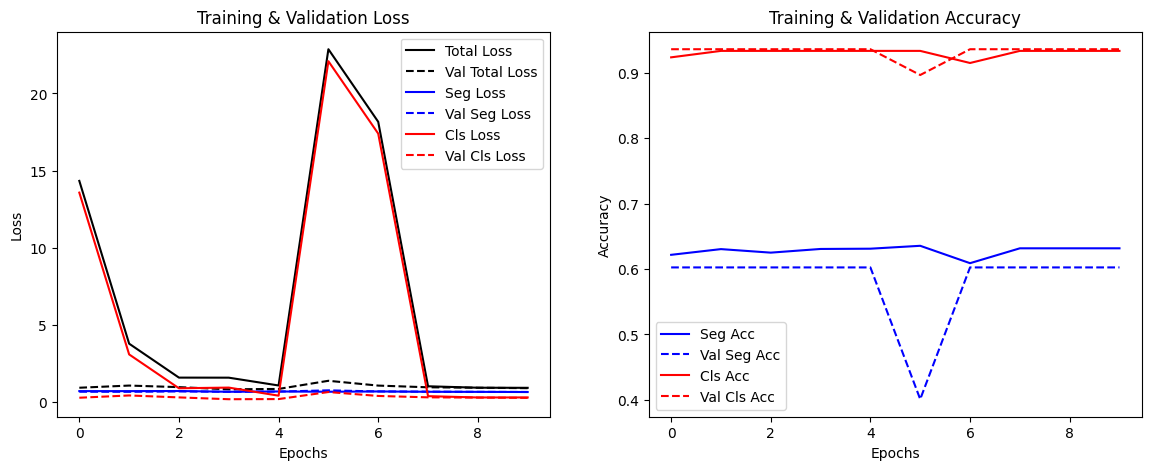

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Convert to dict (sometimes keras history is nested)
    hist = history.history

    # Plot Loss
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='Total Loss', color='black')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='Val Total Loss', color='black', linestyle='--')

    if 'segmentation_loss' in hist:
        plt.plot(hist['segmentation_loss'], label='Seg Loss', color='blue')
    if 'val_segmentation_loss' in hist:
        plt.plot(hist['val_segmentation_loss'], label='Val Seg Loss', color='blue', linestyle='--')

    if 'classification_loss' in hist:
        plt.plot(hist['classification_loss'], label='Cls Loss', color='red')
    if 'val_classification_loss' in hist:
        plt.plot(hist['val_classification_loss'], label='Val Cls Loss', color='red', linestyle='--')

    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    if 'segmentation_accuracy' in hist:
        plt.plot(hist['segmentation_accuracy'], label='Seg Acc', color='blue')
    if 'val_segmentation_accuracy' in hist:
        plt.plot(hist['val_segmentation_accuracy'], label='Val Seg Acc', color='blue', linestyle='--')

    if 'classification_accuracy' in hist:
        plt.plot(hist['classification_accuracy'], label='Cls Acc', color='red')
    if 'val_classification_accuracy' in hist:
        plt.plot(hist['val_classification_accuracy'], label='Val Cls Acc', color='red', linestyle='--')

    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

# Call after training
plot_training_history(history)

Add IoU and Dice Metrics

In [22]:
import tensorflow.keras.backend as K

# Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(K.round(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# IoU (Jaccard index)
def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(K.round(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

Compile Dual-Head Model with Extra Metrics

In [23]:
dual_model.compile(
    optimizer="adam",
    loss={
        "segmentation": "binary_crossentropy",
        "classification": "binary_crossentropy"
    },
    metrics={
        "segmentation": ["accuracy", dice_coefficient, iou_metric],
        "classification": ["accuracy"]
    }
)

Updated Training Curves with IoU & Dice

In [24]:
def plot_training_history(history):
    hist = history.history

    # Plot Loss
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.plot(hist['loss'], label='Total Loss', color='black')
    if 'val_loss' in hist:
        plt.plot(hist['val_loss'], label='Val Total Loss', color='black', linestyle='--')

    if 'segmentation_loss' in hist:
        plt.plot(hist['segmentation_loss'], label='Seg Loss', color='blue')
    if 'val_segmentation_loss' in hist:
        plt.plot(hist['val_segmentation_loss'], label='Val Seg Loss', color='blue', linestyle='--')

    if 'classification_loss' in hist:
        plt.plot(hist['classification_loss'], label='Cls Loss', color='red')
    if 'val_classification_loss' in hist:
        plt.plot(hist['val_classification_loss'], label='Val Cls Loss', color='red', linestyle='--')

    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,3,2)
    if 'segmentation_accuracy' in hist:
        plt.plot(hist['segmentation_accuracy'], label='Seg Acc', color='blue')
    if 'val_segmentation_accuracy' in hist:
        plt.plot(hist['val_segmentation_accuracy'], label='Val Seg Acc', color='blue', linestyle='--')

    if 'classification_accuracy' in hist:
        plt.plot(hist['classification_accuracy'], label='Cls Acc', color='red')
    if 'val_classification_accuracy' in hist:
        plt.plot(hist['val_classification_accuracy'], label='Val Cls Acc', color='red', linestyle='--')

    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot IoU & Dice
    plt.subplot(1,3,3)
    if 'segmentation_iou_metric' in hist:
        plt.plot(hist['segmentation_iou_metric'], label='Train IoU', color='green')
    if 'val_segmentation_iou_metric' in hist:
        plt.plot(hist['val_segmentation_iou_metric'], label='Val IoU', color='green', linestyle='--')

    if 'segmentation_dice_coefficient' in hist:
        plt.plot(hist['segmentation_dice_coefficient'], label='Train Dice', color='purple')
    if 'val_segmentation_dice_coefficient' in hist:
        plt.plot(hist['val_segmentation_dice_coefficient'], label='Val Dice', color='purple', linestyle='--')

    plt.title("Segmentation IoU & Dice")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()

    plt.show()

Visual Evaluation Function

In [27]:
def evaluate_model(dual_model, data_generator, num_samples=5):
    """
    Visualizes segmentation + classification predictions using a data generator.
    """
    import numpy as np
    import random

    # Get a batch from the generator
    # Note: This gets a random batch from the generator's current state.
    # For truly random samples across the whole dataset, you might need
    # a different approach or a generator specifically designed for sampling.
    batch_imgs, batch_targets = next(iter(data_generator))
    images = batch_imgs[:num_samples]
    true_masks = batch_targets["segmentation"][:num_samples]
    true_labels = batch_targets["classification"][:num_samples]


    # Run predictions
    pred_masks, pred_labels = dual_model.predict(images)

    plt.figure(figsize=(15, num_samples*3))

    for i in range(num_samples):
        # Input image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap="gray")
        plt.title(f"GT Mask\nLabel: {'Spill' if true_labels[i]==1 else 'Non-Spill'}")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_masks[i].squeeze() > 0.5, cmap="gray")
        pred_class = "Spill" if pred_labels[i] > 0.5 else "Non-Spill"
        plt.title(f"Pred Mask\nPred Label: {pred_class}\nProb: {pred_labels[i][0]:.2f}")
        plt.axis("off")

        # Overlay GT vs Pred
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(images[i])
        plt.imshow(pred_masks[i].squeeze() > 0.5, cmap="jet", alpha=0.4)
        plt.title("Overlay (Prediction)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Run Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


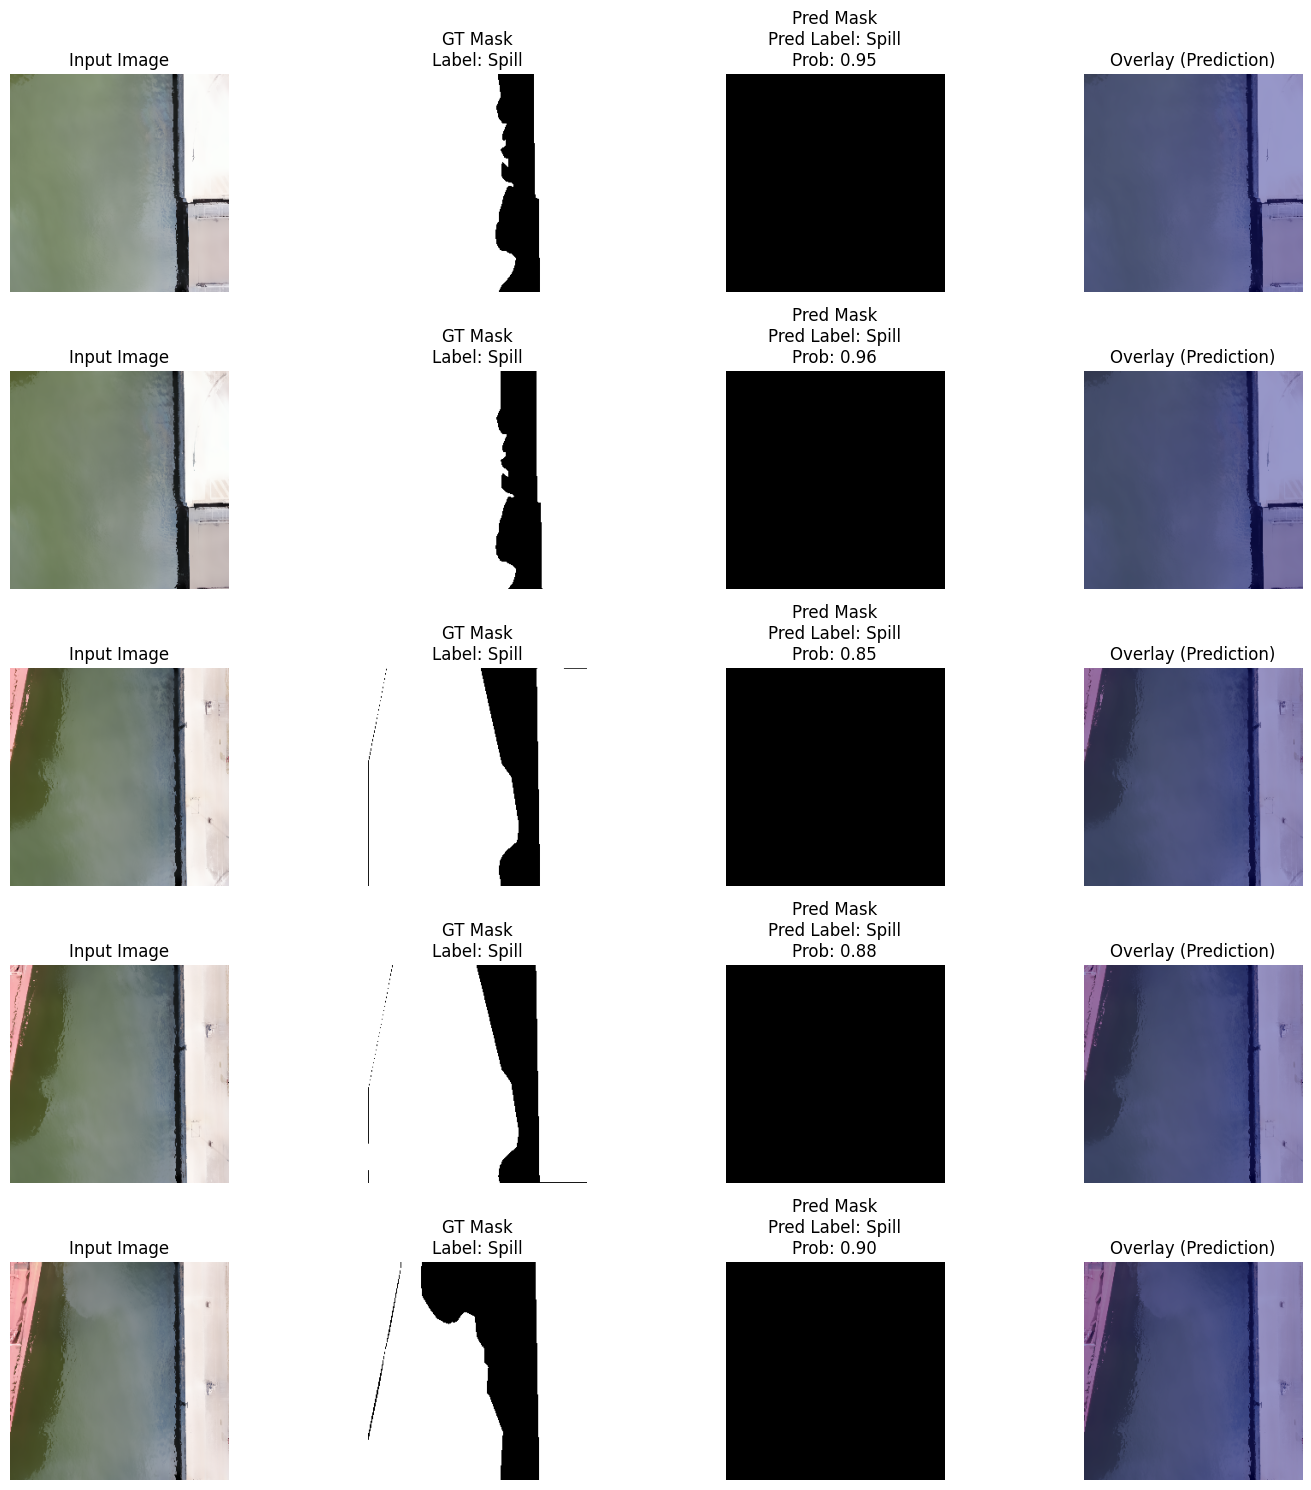

In [28]:
evaluate_model(dual_model, val_gen, num_samples=5)

Classification Metrics

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification(dual_model, X_val, y_val_labels):
    """
    Evaluates classification head (spill vs non-spill).
    """
    # Predict classification only
    _, pred_labels = dual_model.predict(X_val)
    pred_labels_bin = (pred_labels > 0.5).astype(int)

    # Metrics
    # Handle potential case where only one class is present in the subset
    try:
        acc = accuracy_score(y_val_labels, pred_labels_bin)
        prec = precision_score(y_val_labels, pred_labels_bin)
        rec = recall_score(y_val_labels, pred_labels_bin)
        f1 = f1_score(y_val_labels, pred_labels_bin)

        print("🔹 Classification Performance (Spill vs Non-Spill)")
        print(f"Accuracy   : {acc:.4f}")
        print(f"Precision  : {prec:.4f}")
        print(f"Recall     : {rec:.4f}")
        print(f"F1-Score   : {f1:.4f}\n")

        print("🔹 Classification Report")
        # Explicitly specify labels to handle cases with only one class present
        print(classification_report(y_val_labels, pred_labels_bin, target_names=["Non-Spill", "Spill"], labels=[0, 1], zero_division=0))

        print("🔹 Confusion Matrix")
        # Explicitly specify labels to handle cases with only one class present
        print(confusion_matrix(y_val_labels, pred_labels_bin, labels=[0, 1]))

    except ValueError as e:
        print(f"❌ Error generating classification report: {e}")
        print("This might happen if the evaluated data subset contains only one class.")
        # Still print confusion matrix if possible
        try:
            print("\n🔹 Confusion Matrix (Partial)")
            print(confusion_matrix(y_val_labels, pred_labels_bin))
        except Exception as cm_e:
            print(f"Could not generate confusion matrix: {cm_e}")

In [36]:
# Generate classification labels based on mask presence
val_labels = [1 if os.path.exists(mask_path) else 0 for mask_path in val_masks]

# Preprocess validation data into NumPy arrays
X_val, y_val_masks, y_val_labels = preprocess_batch(val_imgs, val_masks, labels=val_labels)

evaluate_classification(dual_model, X_val, y_val_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step
🔹 Classification Performance (Spill vs Non-Spill)
Accuracy   : 1.0000
Precision  : 1.0000
Recall     : 1.0000
F1-Score   : 1.0000

🔹 Classification Report
              precision    recall  f1-score   support

   Non-Spill       0.00      0.00      0.00         0
       Spill       1.00      1.00      1.00       203

    accuracy                           1.00       203
   macro avg       0.50      0.50      0.50       203
weighted avg       1.00      1.00      1.00       203

🔹 Confusion Matrix
[[  0   0]
 [  0 203]]


Per-Image Segmentation Metrics

In [37]:
def evaluate_segmentation_per_image(dual_model, X_val, y_val_masks, threshold=0.5, num_samples=10):
    """
    Computes IoU and Dice per image for segmentation head.
    """
    import numpy as np
    from sklearn.metrics import jaccard_score

    pred_masks, _ = dual_model.predict(X_val)
    pred_masks_bin = (pred_masks > threshold).astype(int)

    iou_scores = []
    dice_scores = []

    for i in range(len(X_val)):
        y_true = y_val_masks[i].flatten()
        y_pred = pred_masks_bin[i].flatten()

        # Handle cases where a mask might be all zeros (no spill)
        if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
             dice = 1.0 # Perfect score for correctly predicting no spill
             iou = 1.0
        elif np.sum(y_true) == 0 or np.sum(y_pred) == 0:
             dice = 0.0 # Predicted spill but no true spill, or vice versa
             iou = 0.0
        else:
            intersection = np.sum(y_true * y_pred)
            union = np.sum(y_true) + np.sum(y_pred)

            dice = (2. * intersection) / (union + 1e-7)
            # Use average="binary" to ensure correct calculation even with single class
            iou = jaccard_score(y_true, y_pred, average="binary", zero_division=0)


        dice_scores.append(dice)
        iou_scores.append(iou)

    print("🔹 Segmentation Performance (Per-Image)")
    print(f"Mean IoU   : {np.mean(iou_scores):.4f}")
    print(f"Mean Dice  : {np.mean(dice_scores):.4f}\n")

    # Show a few hard cases (lowest IoU)
    worst_idxs = np.argsort(iou_scores)[:num_samples]
    print(f"Showing {num_samples} hardest cases...")

    plt.figure(figsize=(15, num_samples*3))
    for j, idx in enumerate(worst_idxs):
        plt.subplot(num_samples, 3, j*3 + 1)
        plt.imshow(X_val[idx])
        plt.title("Input")
        plt.axis("off")

        plt.subplot(num_samples, 3, j*3 + 2)
        plt.imshow(y_val_masks[idx].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, j*3 + 3)
        plt.imshow(pred_masks_bin[idx].squeeze(), cmap="gray")
        plt.title(f"Pred (IoU={iou_scores[idx]:.2f}, Dice={dice_scores[idx]:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step
🔹 Segmentation Performance (Per-Image)
Mean IoU   : 0.6024
Mean Dice  : 0.7020

Showing 5 hardest cases...


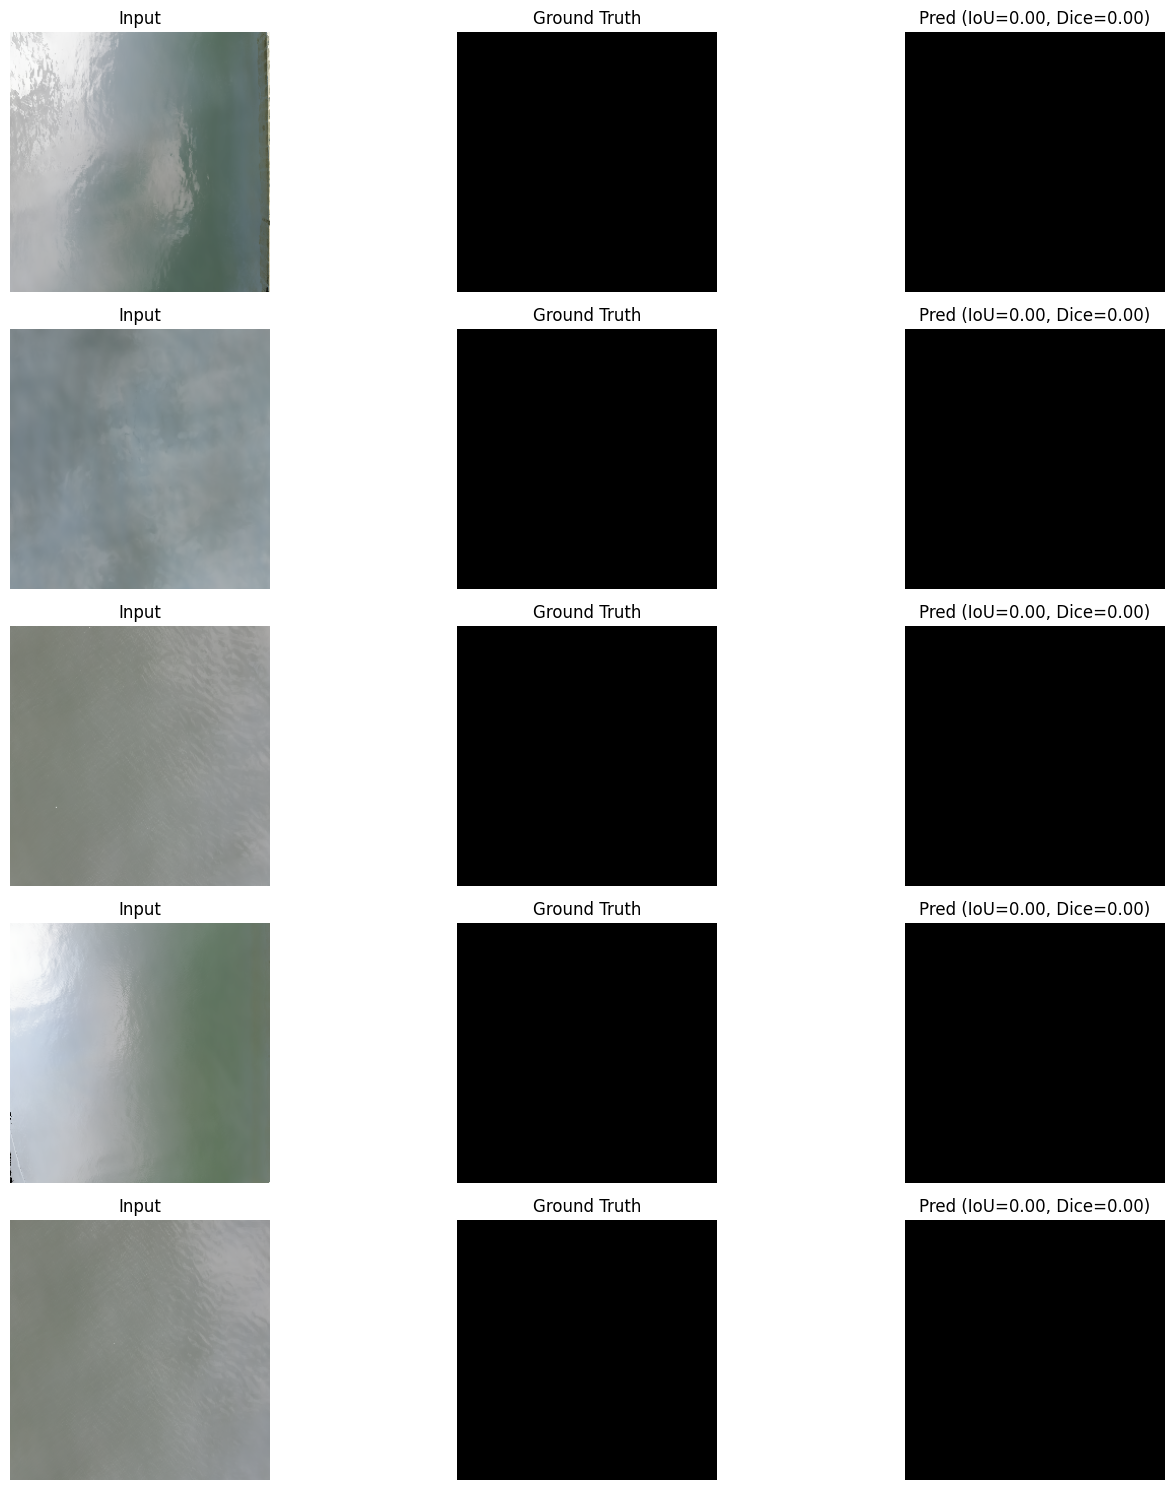

In [38]:
evaluate_segmentation_per_image(dual_model, X_val, y_val_masks, threshold=0.5, num_samples=5)

Joint Per-Image Evaluation (Segmentation + Classification)

In [39]:
def evaluate_joint_per_image(dual_model, X_val, y_val_masks, y_val_labels, threshold=0.5, num_samples=5):
    """
    Joint evaluation: segmentation (IoU, Dice) + classification (Spill/Non-Spill) per image.
    """
    import numpy as np
    from sklearn.metrics import jaccard_score

    # Predictions
    pred_masks, pred_labels = dual_model.predict(X_val)
    pred_masks_bin = (pred_masks > threshold).astype(int)
    pred_labels_bin = (pred_labels > 0.5).astype(int)

    iou_scores, dice_scores = [], []

    for i in range(len(X_val)):
        y_true = y_val_masks[i].flatten()
        y_pred = pred_masks_bin[i].flatten()

        intersection = np.sum(y_true * y_pred)
        union = np.sum(y_true) + np.sum(y_pred)

        dice = (2. * intersection) / (union + 1e-7)
        iou = jaccard_score(y_true, y_pred, average="binary")

        dice_scores.append(dice)
        iou_scores.append(iou)

    # Sort by worst IoU
    worst_idxs = np.argsort(iou_scores)[:num_samples]

    print(f"🔹 Showing {num_samples} hardest cases with classification info...")
    print(f"Mean IoU   : {np.mean(iou_scores):.4f}")
    print(f"Mean Dice  : {np.mean(dice_scores):.4f}\n")

    plt.figure(figsize=(15, num_samples*3))
    for j, idx in enumerate(worst_idxs):
        true_class = "Spill" if y_val_labels[idx] == 1 else "Non-Spill"
        pred_class = "Spill" if pred_labels_bin[idx] == 1 else "Non-Spill"

        plt.subplot(num_samples, 4, j*4 + 1)
        plt.imshow(X_val[idx])
        plt.title("Input")
        plt.axis("off")

        plt.subplot(num_samples, 4, j*4 + 2)
        plt.imshow(y_val_masks[idx].squeeze(), cmap="gray")
        plt.title(f"GT Mask\nClass: {true_class}")
        plt.axis("off")

        plt.subplot(num_samples, 4, j*4 + 3)
        plt.imshow(pred_masks_bin[idx].squeeze(), cmap="gray")
        plt.title(f"Pred Mask\nPred Class: {pred_class}")
        plt.axis("off")

        plt.subplot(num_samples, 4, j*4 + 4)
        plt.imshow(X_val[idx])
        plt.imshow(pred_masks_bin[idx].squeeze(), cmap="jet", alpha=0.4)
        plt.title(f"Overlay\nIoU={iou_scores[idx]:.2f}, Dice={dice_scores[idx]:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step
🔹 Showing 5 hardest cases with classification info...
Mean IoU   : 0.6024
Mean Dice  : 0.7020



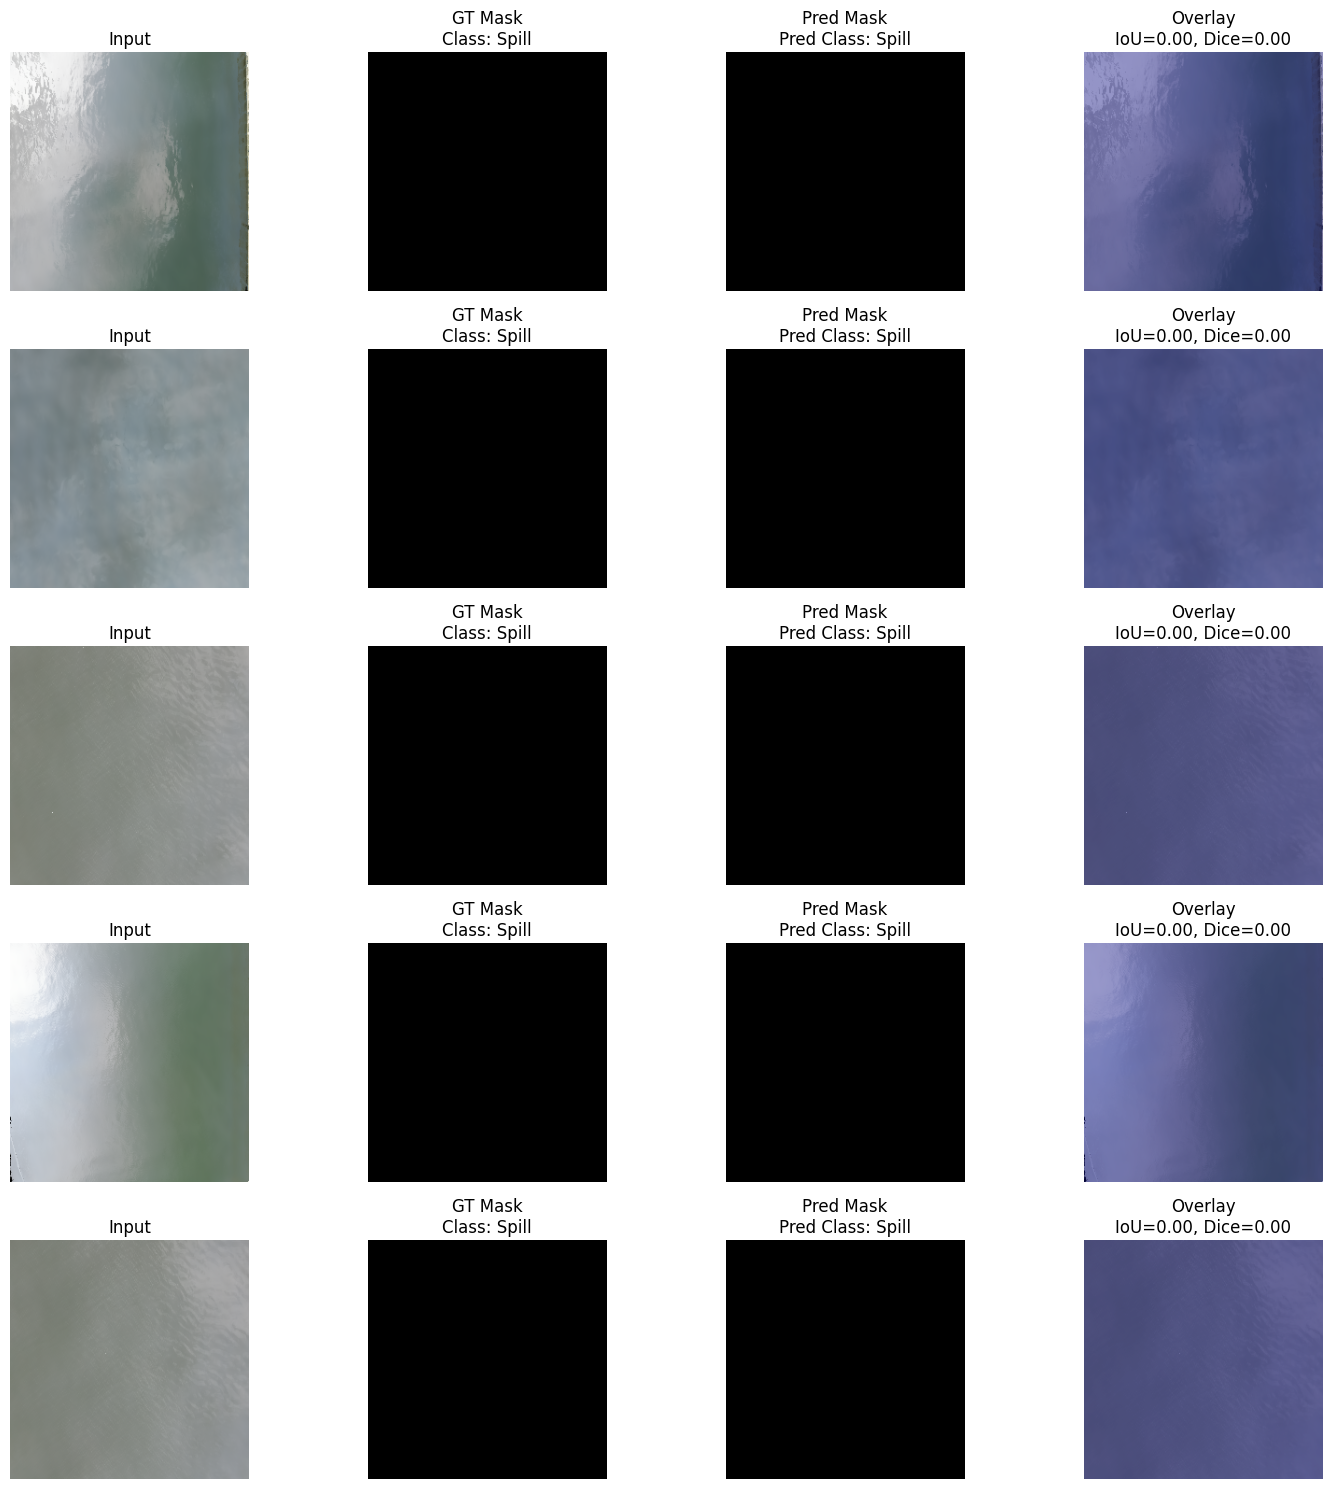

In [40]:
evaluate_joint_per_image(dual_model, X_val, y_val_masks, y_val_labels, threshold=0.5, num_samples=5)